#### **Import Libraries**

In [24]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 

In [25]:
seed = 0 
noise = True 
verbose = False 

In [26]:
np.random.seed(seed)

#### **Set Up Paths**

In [27]:
data_csv = './../../../toy-data/exp2/data_1.csv'

#### **Set Up Plotting**

In [28]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-Italic.ttf


In [29]:
def fstage(race, gender, rent, health, fault):
    return 0.05 + .2*(rent<800.) + 0.5*fault  + 0.1*race*gender

#### Read in Data

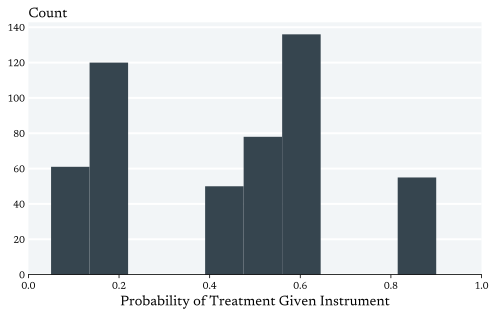

In [30]:
df = pd.read_csv(data_csv)
  
df['FStage_Value'] = df.apply(lambda row: fstage(row['Race'], row['Gender'], row['Rent'], row['Health'], row['Fault']), axis=1)
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Generate Outcome Data**

In [31]:
# Assuming df already exists and has the correct 'Stage_Value' column
n = len(df)  # Get the number of rows in df

# Assign the 'Instrument' column
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)
base_prob = 0.5  # This is an example base probability
df['Treatment'] = np.random.binomial(n=1, p= 0.* (1-df['Instrument']) +  df['FStage_Value'] * df['Instrument'], size=n)
df['Outcome'] = np.random.binomial(n=1, p=df['Treatment'] * 0.5 + 0.25, size=n)

In [32]:
import jax 
import jax.numpy as jnp 
import optax 
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer

In [33]:
df.head()

,Race,Gender,Rent,Health,Fault,Description,FStage_Value,Instrument,Treatment,Outcome
0,0.0,0.0,1214.872282,0.0,1.0,The tenant is a 35-year-old Caucasian male who...,0.50,0,0,0
1,0.0,0.0,1399.222156,1.0,0.0,The tenant is a 57-year-old white male who has...,0.15,0,0,1
2,1.0,0.0,1069.089874,1.0,1.0,The tenant is a 38-year-old African American m...,0.45,1,0,0
3,0.0,1.0,923.439380,1.0,1.0,The tenant is a 42-year-old White female named...,0.05,0,0,1
4,0.0,1.0,777.339738,0.0,0.0,"The tenant is a middle-aged, non-African Ameri...",0.90,1,1,1


In [34]:
X = jnp.array(df[['Race','Gender', 'Rent', 'Health']].values)
# Feature Matrix
min_val = jnp.min(X, axis=0)
max_val = jnp.max(X, axis=0)
X_normalized = (X - min_val) / (max_val - min_val)
print(f"Feature shape: \t\t{X.shape}")

D = jnp.array(df['Treatment'].values.reshape(-1,1)) 
Z = jnp.array(df['Instrument'].values.reshape(-1,1))
inputs = jnp.hstack((X_normalized, Z))

Feature shape: 		(500, 4)


#### **Hyperparameters**

In [35]:
lr = 1e-3
epochs = 1000
nodes = 32
split_frac = 0.5

#### **Model Setup**

In [36]:
features = inputs.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid 
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

Number of Features: 5


#### **Train**

In [37]:
key = jax.random.PRNGKey(0)

# Create Keys
key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

# Initialize the parameters
params = ModelParams.init_fn(subkey1, mlp, features)

# Split Train and Validation Data
idx = jax.random.permutation(subkey2, inputs.shape[0])
is_in_train = jnp.isin(jnp.arange(inputs.shape[0]), idx[:int(split_frac*inputs.shape[0])])
is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), idx[int(split_frac*inputs.shape[0]):])

# Train the model
params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, D, jnp.ones_like(D), is_in_train, is_in_val)

In [38]:
train_loss_history

Array([0.6147455 , 0.61344284, 0.61099714, 0.60758054, 0.60337514,
       0.59856653, 0.59331113, 0.58769846, 0.58184725, 0.5758394 ,
       0.5697546 , 0.56365967, 0.5576026 , 0.55164343, 0.5457991 ,
       0.5400965 , 0.5345394 , 0.52910966, 0.523835  , 0.51873845,
       0.5138204 , 0.50908107, 0.50447315, 0.5000065 , 0.49568605,
       0.49153352, 0.4875378 , 0.48370725, 0.4799332 , 0.47621763,
       0.47264406, 0.46913785, 0.46573627, 0.46244967, 0.45929608,
       0.4562786 , 0.45339862, 0.45065564, 0.44806287, 0.44561225,
       0.44327155, 0.4410249 , 0.43887112, 0.43680635, 0.43482357,
       0.4329014 , 0.43102315, 0.42920905, 0.4274525 , 0.4257474 ,
       0.42408314, 0.42246783, 0.42089948, 0.419374  , 0.41790062,
       0.41646498, 0.4150762 , 0.41373003, 0.4124264 , 0.41116297,
       0.40993434, 0.40874007, 0.40757623, 0.40643978, 0.4053349 ,
       0.40425655, 0.40320474, 0.40217316, 0.40116194, 0.40016523,
       0.39918435, 0.3982222 , 0.3972772 , 0.39634344, 0.39542

#### **Model**

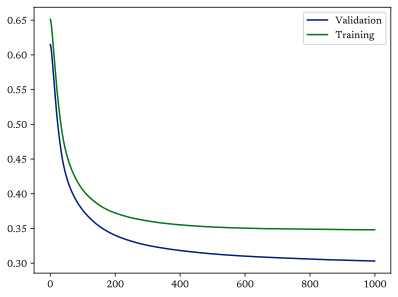

In [39]:
plt.plot(train_loss_history, label='Validation')
plt.plot(val_loss_history, label='Training')
plt.legend()
plt.show()

In [40]:
Dhat = np.array(model.fwd_pass(opt_params, inputs))
Dhat1 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.ones_like(Z)))))
Dhat0 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.zeros_like(Z)))))
residuals = Dhat - (0.5*Dhat1 + 0.5*Dhat0)
est = jnp.linalg.lstsq(jnp.hstack((residuals.reshape(-1,1), jnp.ones_like(residuals.reshape(-1,1)))), jnp.array(df['Outcome'].values.reshape(-1,1)))[0][0]
df = pd.DataFrame({'Estimate': est})

In [41]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/nn_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

: 